# Econ 470 Homework 2
### Author: Ellen Wu

In [13]:
# Importing the libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
from IPython.display import Markdown, display
warnings.simplefilter('ignore')

#Read output datasets
final_HCRIS_data = pd.read_csv('/Users/ellenwu/homework2-2/data/*/output/HCRIS_Data.csv')

\new page

1. How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

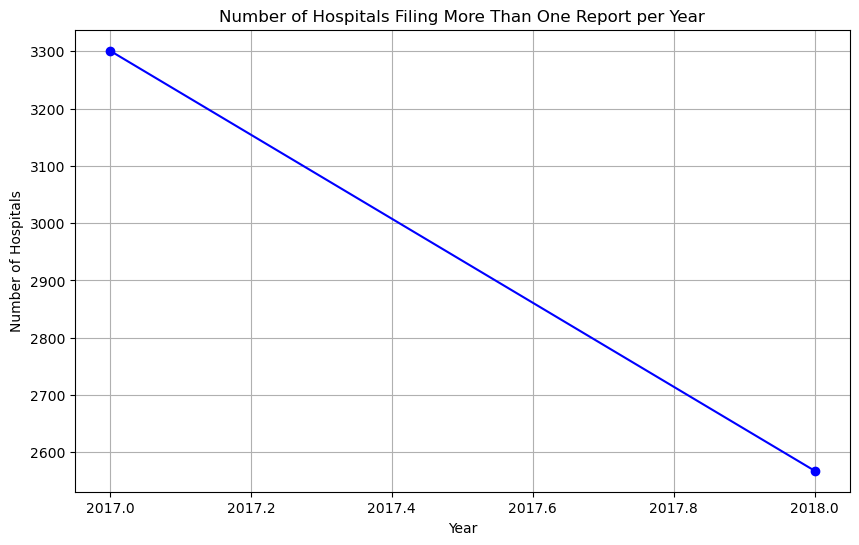

In [14]:
# Count the number of reports per hospital per year
report_counts = final_HCRIS_data.groupby(['year', 'provider_number']).size().reset_index(name='report_count')

# Filter hospitals that filed more than one report in the same year
multiple_reports = report_counts[report_counts['report_count'] > 1]

# Count the number of hospitals per year with multiple reports
hospitals_per_year = multiple_reports.groupby('year').size().reset_index(name='num_hospitals')

# Plot the result as a line graph
plt.figure(figsize=(10, 6))
plt.plot(hospitals_per_year['year'], hospitals_per_year['num_hospitals'], marker='o', linestyle='-', color='blue')
plt.title('Number of Hospitals Filing More Than One Report per Year')
plt.xlabel('Year')
plt.ylabel('Number of Hospitals')
plt.grid(True)
plt.show()

In [22]:
print("Hospitals with multiple reports:\n", multiple_reports.head())
print("Number of hospitals per year:\n", hospitals_per_year)
print(report_counts['report_count'].describe())  # Check min, max, and distribution
print(report_counts[report_counts['report_count'] > 1])

Hospitals with multiple reports:
 Empty DataFrame
Columns: [year, provider_number, report_count]
Index: []
Number of hospitals per year:
 Empty DataFrame
Columns: [year, num_hospitals]
Index: []
count    6173.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: report_count, dtype: float64
Empty DataFrame
Columns: [year, provider_number, report_count]
Index: []


In [5]:
print(report_counts.describe())
print(report_counts.sort_values(by="counts", ascending=False).head(10))

              year  provider_number  report_count
count  6173.000000      6173.000000        6173.0
mean   2018.378908    270174.526324           1.0
std       0.776428    158916.616980           0.0
min    2010.000000     10001.000000           1.0
25%    2018.000000    140187.000000           1.0
50%    2018.000000    260095.000000           1.0
75%    2019.000000    393038.000000           1.0
max    2019.000000    673067.000000           1.0


KeyError: 'counts'

      provider_number  year  counts
0              100001  1999       1
1              100001  2000       1
2              100001  2001       1
3              100001  2002       1
4              100001  2003       1
...               ...   ...     ...
82877           94004  2007       1
82878           94004  2008       1
82879           94004  2009       1
82880           94004  2010       1
82881           94004  2018       1

[82882 rows x 3 columns]


AttributeError: 'NoneType' object has no attribute 'head'

\new page

2. After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [3]:
unique_hospital_ids = HCRIS_Data['provider_number'].nunique()
print(f'The number of unique hospital IDs is: {unique_hospital_ids}')

The number of unique hospital IDs is: 6383


\new page

3. What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis. 

In [4]:
# Filter and preprocess data
charge_data = HCRIS_Data.copy()

#Compute 1st and 99th percentile for total charges per year
charge_data['tot_charges_low'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x,1))
charge_data['tot_charges_high'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x,99))

#Filter out extreme values and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['tot_charges_low']) &
    (charge_data['tot_charges'] < charge_data['tot_charges_high']) &
    charge_data['tot_charges'].notna() & 
    (charge_data['year'] > 1997)
]

#compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

#Prepare data for violin
years = sorted(charge_data['year'].unique())
data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

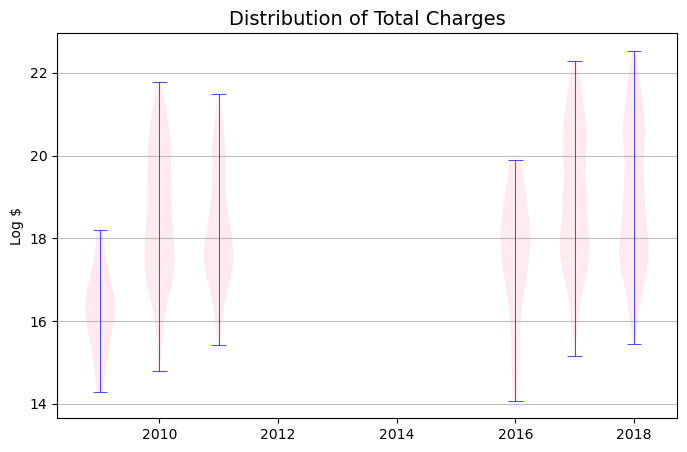

In [5]:
#plot distribution of total charges
fig, ax= plt.subplots(figsize = (8,5))
parts = ax.violinplot(data, positions= years, showmedians= False)

#customize violin plot 
for pc in parts ['bodies']:
    pc.set_facecolor('pink')
    pc.set_alpha (0.3)

for part in ['cbars','cmins', 'cmaxes']:
    parts[part].set_color('blue')
    parts[part].set_linewidth(0.5)

#format plot 
plt.title('Distribution of Total Charges', fontsize= 14)
plt. xlabel('')
plt.ylabel('Log \$')
plt. grid (axis = 'y', color = 'gray', linestyle = '-', alpha = 0.5)
plt.show()

\new page

4. What is the distribution of estimated prices in each year? Again present your results with a violin plot, and recall our formula for estimating prices from class. Be sure to do something about outliers and/or negative prices in the data.

In [6]:
#Compute price data
HCRIS_Data['discount_factor'] = 1 - HCRIS_Data['tot_discounts']/HCRIS_Data['tot_charges']
HCRIS_Data['price_num'] = (
    (HCRIS_Data['ip_charges'] + HCRIS_Data['icu_charges'] + HCRIS_Data['ancillary_charges']) *
    HCRIS_Data['discount_factor']
) - HCRIS_Data ['tot_mcare_payment']
HCRIS_Data['price_denom'] = HCRIS_Data['tot_discharges'] - HCRIS_Data['mcare_discharges']
HCRIS_Data['price'] = HCRIS_Data['price_num'] / HCRIS_Data['price_denom']

#Data filtering
price_data = HCRIS_Data[
    (HCRIS_Data['price_denom'] > 100) &
    (~HCRIS_Data['price_denom'].isna()) &
    (HCRIS_Data['price_num'] > 0) &
    (~HCRIS_Data['price_num'].isna()) &
    (HCRIS_Data['price'] < 100000) &
    (HCRIS_Data['beds'] > 30) &
    (~HCRIS_Data['beds'].isna())
]

# Data preparation 
years= sorted(price_data['year'].unique())
data = [price_data[price_data['year'] == year]['price'].dropna().values for year in years]

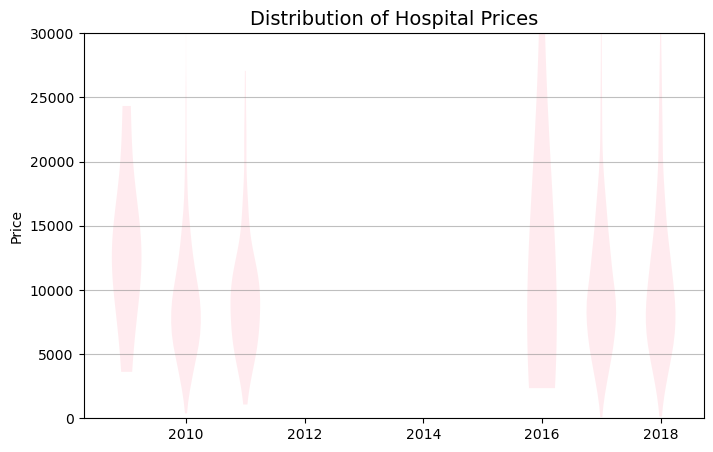

In [7]:
#plot distribution of hospital prices
fig, ax= plt.subplots(figsize = (8,5))
parts = ax.violinplot(data, positions= years, showmedians= False, showextrema=False)

#customize violin plot 
for pc in parts ['bodies']:
    pc.set_facecolor('pink')
    pc.set_alpha (0.3)

#format plot 
plt.ylim(0,30000)
plt.title('Distribution of Hospital Prices', fontsize= 14)
plt. xlabel('')
plt.ylabel('Price')
plt. grid (axis = 'y', color = 'gray', linestyle = '-', alpha = 0.5)
plt.show()

5. Calculate the average price among penalized versus non-penalized hospitals.

In [8]:
# Compute penalty data
price_data.loc[:, 'penalty'] = ((price_data['hvbp_payment'].fillna(0)- price_data['hrrp_payment'].fillna(0).abs()) < 0). astype(int)
# Filter data for year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

print("Columns in pen_data_2012:", pen_data_2012.columns)

Columns in pen_data_2012: Index(['provider_number', 'fy_start', 'fy_end', 'date_processed',
       'date_created', 'beds', 'tot_charges', 'tot_discounts',
       'tot_operating_exp', 'ip_charges', 'icu_charges', 'ancillary_charges',
       'tot_discharges', 'mcare_discharges', 'mcaid_discharges',
       'tot_mcare_payment', 'secondary_mcare_payment', 'street', 'city',
       'state', 'zip', 'county', 'hvbp_payment', 'hrrp_payment', 'year',
       'source', 'discount_factor', 'price_num', 'price_denom', 'price',
       'penalty'],
      dtype='object')


In [9]:
price_data['beds'] = pd.to_numeric(price_data['beds'], errors='coerce')
price_data['price'] = pd.to_numeric(price_data['price'], errors='coerce')

In [10]:
print(pen_data_2012[['price']].describe())

       price
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN


In [13]:

# Ensure numeric conversion
price_data['beds'] = pd.to_numeric(price_data['beds'], errors='coerce')
price_data['price'] = pd.to_numeric(price_data['price'], errors='coerce')

# Compute penalty data
price_data['penalty'] = ((price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0).abs()) < 0).astype(int)

# Filter data for year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

# Compute quartiles
beds_q1 = pen_data_2012['beds'].quantile(0.25)
beds_q2 = pen_data_2012['beds'].quantile(0.50)
beds_q3 = pen_data_2012['beds'].quantile(0.75)
beds_q4 = pen_data_2012['beds'].max()

# Assign bed quartiles
pen_data_2012['bed_quart'] = np.select(
    [
        pen_data_2012['beds'] < beds_q1,
        (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
        (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
        (pen_data_2012['beds'] > beds_q3) & (pen_data_2012['beds'] <= beds_q4),
    ],
    [1, 2, 3, 4],
    default=0
)

# Filter out invalid quartile values
pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

# Compute average price by penalty values
avg_pen = pen_data_2012.groupby('penalty')['price'].mean()

# Display results
display(Markdown(f'Average Price for hospitals with penalty: {avg_pen.get(1, 0):,.2f} and without penalty: {avg_pen.get(0, 0):,.2f}'))

NameError: name 'Markdown' is not defined

In [4]:
# Filter for 2012
df_2012 = HCRIS_Data[HCRIS_Data['year'] == 2012]

# Define penalty as whether the sum of HRRP and HVBP amounts is negative
df_2012['penalty'] = (df_2012['hrrp_payment'] + df_2012['hvbp_payment']) < 0

# Calculate estimated prices
df_2012['discount_factor'] = 1 - (df_2012['tot_discounts'] / df_2012['tot_charges'])
df_2012['price_num'] = (df_2012['ip_charges'] + df_2012['icu_charges'] + 
                        df_2012['ancillary_charges']) * df_2012['discount_factor'] - df_2012['tot_mcare_payment']
df_2012['price_denom'] = df_2012['tot_discharges'] - df_2012['mcare_discharges']
df_2012['estimated_price'] = df_2012['price_num'] / df_2012['price_denom']

# Remove negative prices and extreme outliers
df_cleaned = df_2012[(df_2012['estimated_price'] > 0) & 
                     (df_2012['estimated_price'] < df_2012['estimated_price'].quantile(0.99))]

# Calculate average price among penalized vs non-penalized hospitals
avg_price_penalty = df_cleaned.groupby('penalty')['estimated_price'].mean()

print(avg_price_penalty)

Series([], Name: estimated_price, dtype: float64)


6. Provide a table of the average price among treated/control groups for each quartile.

In [11]:
# Compute average price by penalty status and bed quartile 
avg_pen = pen_data_2012.groupby(['penalty', 'bed_quart'])[['price']].mean().unstack(level=0)

#change the name of index and columns 
avg_pen.columns = avg_pen.columns.droplevel()
avg_pen.columns = ['Not Penalized', 'Penalized']
avg_pen. columns.name = ''
avg_pen.index.name = 'Bed Size'

#Display table
display(Markdown(avg_pen.to_markdown()))

KeyError: 'bed_quart'

In [12]:
print(pen_data_2012[['penalty', 'bed_quart', 'price']].isnull().sum())  # Count NaNs
print(pen_data_2012[['penalty', 'bed_quart', 'price']].dropna().shape)  # Check valid rows

KeyError: "['bed_quart'] not in index"

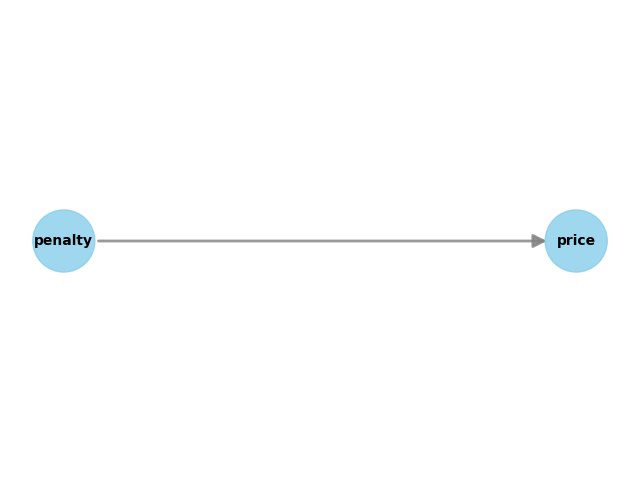

AttributeError: 'CausalModel' object has no attribute 'est_via_matching'

In [71]:
#Create bed quartile dummies for models
bed_quarts = pd.get_dummies(pen_data_2012['bed_quart'],prefix='bed_quart').iloc[:, :-1] * 1
bed_quarts = bed_quarts.sub(bed_quarts.mean(axis=0), axis = 1)

# Ensure data is formatted correctly
pen_data_2012['penalty'] = pen_data_2012['penalty'].astype(int)  # Ensure binary treatment variable

# Initialize CausalModel correctly
cm = CausalModel(
    data=pen_data_2012,         # Pass the entire DataFrame
    treatment='penalty',        # Treatment variable
    outcome='price',            # Outcome variable
    common_causes=list(bed_quarts.columns)  # Covariates (bed quartiles)
)

# Display the causal graph (optional)
cm.view_model()

results= pd.DataFrame(index=['ATE', 'SE'], columns= ['INV, MAH', 'IPW', 'OLS'])
cm.est_via_matching(weights='inv', matches=1, bias_adj= True)
results.loc['ATE','INV'] = cm.estimates['matching']['ate']
results.loc['SE','INV'] = cm.estimates['matching']['ate_se']

cm.est_via_matching(weights='maha', matches=1, bias_adj= True)
results.loc['ATE','MAH'] = cm.estimates['matching']['ate']
results.loc['SE','MAH'] = cm.estimates['matching']['ate_se']

cm.est_propensity()
cm.est_via_weighting()
results.loc['ATE','IPW'] = cm.estimates['weighting']['ate']
results.loc['SE','MAH'] = cm.estimates['weighting']['ate_se']

cm.est_via_ols(adj=2)
results.loc['ATE','OLS'] = cm.estimates['ols']['ate']
results.loc['SE','OLS'] = cm.estimates['ols']['ate_se']

results = results.astype(float).round(2)
display(Markdown(results.to_markdown()))

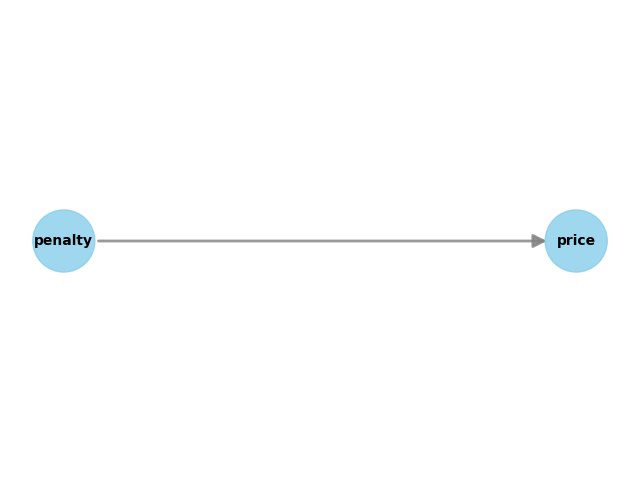

AttributeError: 'CausalModel' object has no attribute 'est_via_matching'

In [72]:
# Ensure data is formatted correctly
price_data['beds'] = pd.to_numeric(price_data['beds'], errors='coerce')
price_data['price'] = pd.to_numeric(price_data['price'], errors='coerce')

# Compute penalty data
price_data['penalty'] = ((price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0).abs()) < 0).astype(int)

# Filter data for year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

# Compute quartiles
beds_q1 = pen_data_2012['beds'].quantile(0.25)
beds_q2 = pen_data_2012['beds'].quantile(0.50)
beds_q3 = pen_data_2012['beds'].quantile(0.75)
beds_q4 = pen_data_2012['beds'].max()

# Assign bed quartiles
pen_data_2012['bed_quart'] = np.select(
    [
        pen_data_2012['beds'] < beds_q1,
        (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
        (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
        (pen_data_2012['beds'] > beds_q3) & (pen_data_2012['beds'] <= beds_q4),
    ],
    [1, 2, 3, 4],
    default=0
)

# Filter out invalid quartile values
pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

# Create bed quartile dummies for models
bed_quarts = pd.get_dummies(pen_data_2012['bed_quart'], prefix='bed_quart').iloc[:, :-1] * 1
bed_quarts = bed_quarts.sub(bed_quarts.mean(axis=0), axis=1)

# Ensure data is formatted correctly
pen_data_2012['penalty'] = pen_data_2012['penalty'].astype(int)  # Ensure binary treatment variable

# Initialize CausalModel correctly
cm = CausalModel(
    data=pen_data_2012,         # Pass the entire DataFrame
    treatment='penalty',        # Treatment variable
    outcome='price',            # Outcome variable
    common_causes=list(bed_quarts.columns)  # Covariates (bed quartiles)
)

# Display the causal graph (optional)
cm.view_model()

results = pd.DataFrame(index=['ATE', 'SE'], columns=['INV', 'MAH', 'IPW', 'OLS'])

# Nearest neighbor matching (1-to-1) with inverse variance distance
cm.est_via_matching(weights='inv', matches=1, bias_adj=True)
results.loc['ATE', 'INV'] = cm.estimates['matching']['ate']
results.loc['SE', 'INV'] = cm.estimates['matching']['ate_se']

# Nearest neighbor matching (1-to-1) with Mahalanobis distance
cm.est_via_matching(weights='maha', matches=1, bias_adj=True)
results.loc['ATE', 'MAH'] = cm.estimates['matching']['ate']
results.loc['SE', 'MAH'] = cm.estimates['matching']['ate_se']

# Inverse propensity weighting
cm.est_propensity()
cm.est_via_weighting()
results.loc['ATE', 'IPW'] = cm.estimates['weighting']['ate']
results.loc['SE', 'IPW'] = cm.estimates['weighting']['ate_se']

# Simple linear regression
cm.est_via_ols(adj=2)
results.loc['ATE', 'OLS'] = cm.estimates['ols']['ate']
results.loc['SE', 'OLS'] = cm.estimates['ols']['ate_se']

results = results.astype(float).round(2)
display(results)

In [73]:
from dowhy import CausalModel
import pandas as pd

# Ensure treatment variable is correctly formatted
pen_data_2012['penalty'] = pen_data_2012['penalty'].astype(int)

# Initialize CausalModel correctly
cm = CausalModel(
    data=pen_data_2012,
    treatment='penalty',
    outcome='price',
    common_causes=list(bed_quarts.columns)
)

# Identify the effect
identified_estimand = cm.identify_effect()

# Estimate effect using Matching (Replaces est_via_matching)
estimate_matching = cm.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

# Estimate effect using Weighting (Replaces est_via_weighting)
estimate_weighting = cm.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)

# Estimate effect using OLS (Replaces est_via_ols)
estimate_ols = cm.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

# Store results in DataFrame
results = pd.DataFrame(index=['ATE'], columns=['Matching', 'Weighting', 'OLS'])
results.loc['ATE', 'Matching'] = estimate_matching.value
results.loc['ATE', 'Weighting'] = estimate_weighting.value
results.loc['ATE', 'OLS'] = estimate_ols.value

# Display results
from IPython.display import display, Markdown
display(Markdown(results.to_markdown()))

Exception: No common causes/confounders present. Propensity score based methods are not applicable

In [74]:
print(bed_quarts.head())  # Check if it has values
print(pen_data_2012.columns)  # Ensure bed_quarts is in the dataset

Empty DataFrame
Columns: []
Index: []
Index(['provider_number', 'fy_start', 'fy_end', 'date_processed',
       'date_created', 'beds', 'tot_charges', 'tot_discounts',
       'tot_operating_exp', 'ip_charges', 'icu_charges', 'ancillary_charges',
       'tot_discharges', 'mcare_discharges', 'mcaid_discharges',
       'tot_mcare_payment', 'secondary_mcare_payment', 'street', 'city',
       'state', 'zip', 'county', 'hvbp_payment', 'hrrp_payment', 'year',
       'source', 'discount_factor', 'price_num', 'price_denom', 'price',
       'penalty', 'bed_quart'],
      dtype='object')


In [75]:
pen_data_2012 = pd.concat([pen_data_2012, bed_quarts], axis=1)